# Assignments 2 and 3 Notebook

In [1]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
from collections import defaultdict
import simplejson as json
import collections
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import io
from sklearn.svm import LinearSVC
import gzip
import random
import os
import itertools
import pathlib
import re 
from scipy import sparse
from sklearn import svm
from scipy.stats import uniform
from tqdm import tqdm

In [2]:
'''
A method that creates the necessary file structure that will be used to
store the APK downloads
'''

def createDir():

    cwd = os.getcwd()
    file = str(cwd) + '/EDA'
    file2 = file + '/APK_Downloads/'

    if os.path.isdir(file) == False:
        os.mkdir(file)
        if os.path.isdir(file2) == False:
            os.mkdir(file2)

    return file2

PATH = createDir()
PATH

'/home/kelkin/EDA/APK_Downloads/'

In [3]:
# To get the same amount of malware apps 

def countBenign(dic):
    List_flat = list(itertools.chain(*dic.values()))
    return len(List_flat)

In [23]:
#get immediate subdirectories of each subdirectories from above. Key is the catagory of app and value is the app name
#gives you all the apps for a given catagory

def catagoryApps(path):
    
    #get immediate subdirectories of PATH 
    list_subfolders_with_paths = [f.path for f in os.scandir(PATH) if f.is_dir()]
    directDic = {}

    for direct in list_subfolders_with_paths:
        subdirs = []
        for sub in os.scandir(direct):
            if sub.is_dir():
                subdirs.append(sub.name)
        directDic[direct.split("/")[-1]] = subdirs

    return directDic

directDic = catagoryApps(PATH)
directDic

{'.ipynb_checkpoints': [],
 'tools': ['tools_31',
  'tools_0',
  'tools_22',
  'tools_28',
  'tools_17',
  'tools_41',
  'tools_32',
  'tools_3',
  'tools_13',
  'tools_14',
  'tools_42',
  'tools_35',
  'tools_40',
  'tools_16',
  'tools_24',
  'tools_23',
  'tools_11',
  'tools_30',
  '.ipynb_checkpoints',
  'tools_1',
  'tools_34',
  'tools_15',
  'tools_20',
  'tools_18',
  'tools_39',
  'tools_44'],
 'comics': ['comics_22',
  'comics_28',
  'comics_31',
  'comics_25',
  'comics_2',
  'comics_17',
  'comics_6',
  'comics_19',
  'comics_13',
  'comics_21',
  '.ipynb_checkpoints',
  'comics_26',
  'comics_14',
  'comics_1',
  'comics_3',
  'comics_16',
  'comics_30',
  'comics_11',
  'comics_4',
  'comics_29',
  'comics_27',
  'comics_15',
  'comics_0',
  'comics_7',
  'comics_12',
  'comics_20']}

In [5]:
# def malware_app_paths():
#     malware_loc = []
#     dir_list = os.listdir("/datasets/dsc180a-wi20-public/Malware/amd_data_smali")
#     for i in dir_list:
#         string = '/datasets/dsc180a-wi20-public/Malware/amd_data_smali/' + i
#         lis = os.listdir(string)
#         for variety in lis:
#             new_string = string + '/' + variety
#             app_list = os.listdir(new_string)
#             for app in app_list:
#                 final_str = new_string + '/' + app
#                 malware_loc.append(final_str)
#     return malware_loc
# mal = malware_app_paths()[:7]
# mal

# Create Data Structure (make_dataset)

In [7]:
# def getAPICalls(catagory, appName, methodIDCount, invokeType)
#     methodID = 'method_' + str(methodIDCount)
#     methodList.append(line)
#     catDict[catagory][appName]['Methods'][methodID] = methodList
#     result = re.sub(pat, '', s)
#     result = result[2:-2]
                

#gets each app name in the catagory 

#next steps - 1) open up directory for each app name 2) find the smali file in this directory 


patAPI = re.compile('^[^}]*}')
patPack = re.compile('^(.*?)->')
parChar = re.compile('[^(]*')

def dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType):

    
    methodID = 'method_' + str(methodIDCount)
    result = re.sub(patAPI, '', str(line))
    apiCall = result[2:]
    apiNoParam = re.match(parChar, apiCall)


    apiCall = apiNoParam.group(0) + str('()')
    package = re.search(patPack, apiCall)

    catDict[catagory][appName]['Packages'][package.group(1)].append(apiCall)
    catDict[catagory][appName]['All_APIs']['APIs'].append(apiCall)
    catDict[catagory][appName]['Invoke_Type'][invokeType].append(apiCall)
    catDict[catagory][appName]['Methods'][methodID].append(apiCall)


def getUniqueAPIs(catDict, catagory, appName):
    
    #get the set of all APIs for an app with the same invoke type and put them into a list
    invokeTypes = ['invoke-static', 'invoke-virtual', 'invoke-direct', 'invoke-super', 'invoke-interface']
    
    for invoke in invokeTypes:
        catDict[catagory][appName]['Invoke_Type'][invoke] = list(set(catDict[catagory][appName]['Invoke_Type'][invoke]))
    
    #get the set of all APIs for an app that are called in the application
    catDict[catagory][appName]['All_APIs']['APIs'] = list(set(catDict[catagory][appName]['All_APIs']['APIs']))
    
    #get the set of all packages in an app that are used in an application
    for pack in catDict[catagory][appName]['Packages']:
        catDict[catagory][appName]['Packages'][pack] = list(set(catDict[catagory][appName]['Packages'][pack]))
        

'''
A method that creates a json object of the data structure 

'''    
def createDataStructure(path):

    catDict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))


    methodIDCount = 0
    methodList = []
    inMethod = False
    methodID = 'method_' + str(methodIDCount)
    
    
    startMethod = '.method'
    endMethod = '.end method'
    

    
    directDic = catagoryApps(path)
    for catagory in directDic:

        for appName in directDic[catagory]:
            #get path of appname in dir
            newPath = PATH + str(catagory) + '/' + str(appName) + '/' + 'smali'
            if os.path.isdir(newPath):
                #go into smali file and get all the .methods and .endmethods using regex
                #assign unique id for each method (key) which will have a list of API calls for the values
                samliFiles = glob.glob(newPath + '/**/*.smali', recursive=True)
                #read each smali file and get the method calls 
                for file in samliFiles:
                    f = open(file, "r")
                    Lines = f.readlines()
                    for line in Lines:
                        if startMethod in line:
                            inMethod = True

                        if inMethod and (endMethod in line):
                            inMethod = False
                            methodIDCount += 1
                            methodList = []

                        if (inMethod) and ('invoke-static' in line): 
                            invokeType = 'invoke-static'
                            dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType)

                        if (inMethod) and ('invoke-virtual' in line):
                            invokeType = 'invoke-virtual'
                            dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType)

                        if (inMethod) and ('invoke-direct' in line): 
                            invokeType = 'invoke-direct'
                            dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType)

                        if (inMethod) and ('invoke-super' in line): 
                            invokeType = 'invoke-super'
                            dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType)

                        if (inMethod) and ('invoke-interface' in line):
                            invokeType = 'invoke-interface'
                            dataStructureHelper(catagory, appName, line, methodIDCount, catDict, invokeType)

            getUniqueAPIs(catDict, catagory, appName)
            
    return catDict

catDict = createDataStructure(PATH)

In [10]:
# Getting the APIs called in the same method for one of the codeblocks found 
# (this is for the tools catagory and the tools_31 app)
catDict['tools']['tools_31']['Methods']['method_113']

['Ljava/lang/Integer;->intValue()',
 'Ljava/lang/Integer;->intValue()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->pow()',
 'Ljava/lang/Math;->round()',
 'Ljava/lang/Math;->round()',
 'Ljava/lang/Math;->round()',
 'Ljava/lang/Math;->round()',
 'Ljava/lang/Integer;->valueOf()']

# Get Index Locations for Matricies

In [15]:
#get a list of every possible api call in all the apps and take the set of it. This will be the 
def allAPIsDataset(catDict):
    
    allAPIs = []
    for catagory in catDict:
        for appName in catDict[catagory]:
            allAPIs = allAPIs + list(catDict[catagory][appName]['All_APIs']['APIs'])
    allAPIs = list(set(allAPIs))
    
    return allAPIs

# Make a new dictionary containing unique API and there index
def uniqueDict(jsonFile):

    UniqueIDAPI = {}
    idMaker = 0
    for i in allAPIsDataset(jsonFile):
        UniqueIDAPI[i] = idMaker
        idMaker += 1
    
    return UniqueIDAPI

UniqueIDAPI = uniqueDict(catDict)

#For demonstration: Show unique ID of this API in the dictionary
UniqueIDAPI['Lde/shellfire/vpn/android/MainTabletActivity$ServerSelectSectionFragment;->getResources()']


656

In [18]:
#get all the possible app names 
def allApps(jsonFile):
    
    allApps = []
    for catagory in catDict:
        allApps = allApps + list(catDict[catagory])
    return allApps

# Make a new dictionary containing unique apps and there index
def UniqueApps(jsonFile): 
    
    UniqueIDApp = {}
    idMakerApp = 0
    
    for i in allApps(jsonFile):
        UniqueIDApp[i] = idMakerApp
        idMakerApp += 1
    
    return UniqueIDApp

UniqueIDApp = UniqueApps(catDict)

#For demonstration: Show unique ID of this app in the dictionary
UniqueIDApp['comics_28']

27

# A-Matrix, B-Matrix, P-Matrix, I-Matrix

In [19]:
# Sparse MatrixA
def aMatrixSparse(catDict):
    
    appIdxRows = []
    apiIdxCols = []
    data = []
    
    for catagory in catDict:
        for appName in catDict[catagory]:
            print(catDict[catagory][appName])
            for api in list(catDict[catagory][appName]['All_APIs']['APIs']):
                appIdxRows.append(UniqueIDApp[appName])
                apiIdxCols.append(UniqueIDAPI[api])
                data.append(1)
                
    return sparse.coo_matrix((data, (appIdxRows, apiIdxCols)))

aMatrix = aMatrixSparse(catDict)
aMatrix

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<52x341052 sparse matrix of type '<class 'numpy.int64'>'
	with 1033856 stored elements in COOrdinate format>

In [ ]:
#Find the adjacency matrix for methods that exist in the same code block MatrixB
def bMatrixSparse(catDict):
    
    appIdxRows = []
    apiIdxCols = []
    data = []

    for catagory in catDict:
        for appName in catDict[catagory]:
            keylist = list(catDict[catagory][appName]['Methods'].keys())
            methodList = [[item for item in catDict[catagory][appName]['Methods'][key]] for key in keylist]

            for i in methodList:
                for j in i:
                    for k in i:
                        appIdxRows.append(UniqueIDAPI[j])
                        apiIdxCols.append(UniqueIDAPI[k])
                        data.append(1)
                        
                        appIdxRows.append(UniqueIDAPI[k])
                        apiIdxCols.append(UniqueIDAPI[j])
                        data.append(1)
                        
    return sparse.coo_matrix((data, (appIdxRows, apiIdxCols)))

bMatrix = bMatrixSparse(catDict)
bMatrix

In [ ]:
#Find the adjacency matrix for methods that exist in the same package MatrixP
def pMatrixSparse(catDict):
    
    appIdxRows = []
    apiIdxCols = []
    data = []

    for catagory in catDict:
        for appName in catDict[catagory]:
            keylist = list(catDict[catagory][appName]['Packages'].keys())
            packageList = [[item for item in catDict[catagory][appName]['Packages'][key]] for key in keylist]

            for i in packageList:
                for j in i:
                    for k in i:
                        appIdxRows.append(UniqueIDAPI[j])
                        apiIdxCols.append(UniqueIDAPI[k])
                        data.append(1)
                        
                        appIdxRows.append(UniqueIDAPI[k])
                        apiIdxCols.append(UniqueIDAPI[j])
                        data.append(1)
                        
    return sparse.coo_matrix((data, (appIdxRows, apiIdxCols)))

pMatrix = pMatrixSparse(catDict)
pMatrix

In [ ]:
def iMatrixSparse(catDict, UniqueIDAPI):

    appIdxRows = []
    apiIdxCols = []
    data = []

    #Find the adjacency matrix for methods that exist in the same invoke method MatrixI
    print("Creating The I-Matrix....")
    for catagory in tqdm(catDict):
        for appName in catDict[catagory]:
            keylist = list(catDict[catagory][appName]['Invoke_Type'].keys())
            invokeList = [[item for item in catDict[catagory][appName]['Invoke_Type'][key]] for key in keylist]

            for i in invokeList:
                for j in i:
                    for k in i:
                        appIdxRows.append(UniqueIDAPI[j])
                        apiIdxCols.append(UniqueIDAPI[k])
                        data.append(1)

                        appIdxRows.append(UniqueIDAPI[k])
                        apiIdxCols.append(UniqueIDAPI[j])
                        data.append(1)

    return sparse.coo_matrix((data, (appIdxRows, apiIdxCols)))

In [ ]:
# Kernel multiplication

# Transpose
def trans(Matrix):
    return Matrix.transpose()

# AA^T
def AAtrans(MatrixA, MatrixATrans):
    return MatrixA.dot(MatrixATrans)

# # ABA^T
def ABAtrans(MatrixA, MatrixB, MatrixATrans):
    AdotB = MatrixA.dot(MatrixB)
    return AdotB.dot(MatrixATrans)

# # APA^T
def APAtrans(MatrixA, MatrixP, MatrixATrans):
    AdotP = MatrixA.dot(MatrixP)
    return AdotP.dot(MatrixATrans)

# APBP^TA^T
def APBPtransAtrans(MatrixA, MatrixB, MatrixP, MatrixATrans, MatrixPTrans):
    AdotP = MatrixA.dot(MatrixP)
    AdotPdotB = AdotP.dot(MatrixB)
    prevDotPtrans = AdotPdotB.dot(MatrixPTrans)
    prevDotAtrans = prevDotPtrans.dot(MatrixATrans)
    return prevDotAtrans
    





In [ ]:
def createSVM(ker):
    
    df = pd.DataFrame(ker)
    df['Classification_id'] = UniqueIDApp.keys()
    df['Classification_id'] = df['Classification_id'].apply(lambda x: 'malware' if 'Malware' in x else 'benign')

    feature_cols = df.iloc[:,:-1]
    X = feature_cols # Features
    y = df['Classification_id'] # Target variable
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    accuracy = fitted.score(X_test, y_test)
    print('----------------------------------------------------------')
    print('Accuracy:  ' + str(accuracy))
    print('----------------------------------------------------------')
    f1 = f1_score(y_test, pred, average='weighted')
    print('F1_score:  ' + str(f1))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    print('Confusion_matrix')
    print('----------------------------------------------------------')
    print('tn: ' + str(tn) + '  |  fp: ' + str(fp) + '  |  tn: ' + str(tn) + '  |  tp: ' + str(tp))
    return accuracy

print('AA^T')
createSVM(AAtrans(aMatrix, aMatrix.T).toarray())
print('----------------------------------------------------------')
print('\n')
print('ABA^T')
createSVM(ABAtrans(aMatrix, bMatrix, aMatrix.T).toarray())
print('----------------------------------------------------------')
print('\n')
print('APA^T')
createSVM(APAtrans(aMatrix, pMatrix, aMatrix.T).toarray())
print('----------------------------------------------------------')
print('\n')
print('APBP^TA^T')
createSVM(APBPtransAtrans(aMatrix, bMatrix, pMatrix, aMatrix.T, pMatrix.T).toarray())
print('----------------------------------------------------------')

# EDA and Baseline model (Improved from Assignment 2)

In [80]:
### Get the number of unique API calls 
catagory1 = 'tools'
catagory2 = 'comics'

numCat = countBenign(directDic)/2 - 1
catagory1Count = int(numCat)
catagory2Count = int(numCat)

cat1List = []
cat2List = []
cat1CountAPI = []
cat2CountAPI = []
cat1Pack = []
cat2Pack = []
cat1ListPack = 0
cat2ListPack = 0

cat1Static = 0
cat1Virtual = 0
cat1Direct = 0
cat1Super = 0
cat1Inter = 0

cat2Static = 0
cat2Virtual = 0
cat2Direct = 0
cat2Super = 0
cat2Inter = 0

invokeTypes = ['invoke-static', 'invoke-virtual', 'invoke-direct', 'invoke-super', 'invoke-interface']

for appName in catDict[catagory1]:
    cat1List = cat1List + list(catDict[catagory1][appName]['All_APIs']['APIs'])
    cat1CountAPI.append(len(list(catDict[catagory1][appName]['All_APIs']['APIs'])))

cat1List = set(cat1List)



for appName in catDict[catagory2]:
    cat2List = cat2List + list(catDict[catagory2][appName]['All_APIs']['APIs'])
    cat2CountAPI.append(len(list(catDict[catagory2][appName]['All_APIs']['APIs'])))
cat2List = set(cat2List)



totalNumUnique1 = len(cat1List)
totalNumUnique2 = len(cat2List)

print('Unique API count by Catagory\n')

print('totalNumUniqueTools: ' + str(totalNumUnique1) +'\n')
print('totalNumUniqueComics: ' + str(totalNumUnique2) +'\n')

avgUnique1 = totalNumUnique1 / catagory1Count
avgUnique2 = totalNumUnique2 / catagory2Count

print('avgUniqueTools: ' + str(avgUnique1) +'\n')
print('avgUniqueComics: ' + str(avgUnique2) +'\n')
print('----------------------------------------------------\n')

### Get the total number of Packages
print('Number of Packages by type per catagory\n')
for appName in catDict[catagory1]:
    for pack in catDict[catagory1][appName]['Packages']:
        cat1ListPack = cat1ListPack + len(list(catDict[catagory1][appName]['Packages'][pack]))
        cat1Pack.append(len((catDict[catagory1][appName]['Packages'][pack])))


for appName in catDict[catagory2]:
     for pack in catDict[catagory2][appName]['Packages']:
        cat2ListPack = cat2ListPack + len(list(catDict[catagory2][appName]['Packages'][pack]))
        cat2Pack.append(len((catDict[catagory2][appName]['Packages'][pack])))



totalNumPack1 = cat1ListPack
totalNumPack2 = cat2ListPack

print('totalNumPackTools: ' + str(totalNumPack1) +'\n')
print('totalNumPackComics: ' + str(totalNumPack2) +'\n')

avgUniquePack1 = totalNumPack1 / catagory1Count
avgUniquePack2 = totalNumPack2 / catagory2Count

print('avgUniquePackTools: ' + str(avgUniquePack1) +'\n')
print('avgUniquePackComics: ' + str(avgUniquePack2) +'\n')
print('----------------------------------------------------\n')
### Number of API calls by type per catagory

for appName in catDict[catagory1]:

    cat1Static = cat1Static + len(list(catDict[catagory1][appName]['Invoke_Type']['invoke-static']))
    cat1Virtual = cat1Virtual + len(list(catDict[catagory1][appName]['Invoke_Type']['invoke-virtual']))
    cat1Direct = cat1Direct + len(list(catDict[catagory1][appName]['Invoke_Type']['invoke-direct']))
    cat1Super = cat1Super + len(list(catDict[catagory1][appName]['Invoke_Type']['invoke-super']))
    cat1Inter = cat1Inter + len(list(catDict[catagory1][appName]['Invoke_Type']['invoke-interface']))

for appName in catDict[catagory2]:

    cat2Static = cat2Static + len(list(catDict[catagory2][appName]['Invoke_Type']['invoke-static']))
    cat2Virtual = cat2Virtual + len(list(catDict[catagory2][appName]['Invoke_Type']['invoke-virtual']))
    cat2Direct = cat2Direct + len(list(catDict[catagory2][appName]['Invoke_Type']['invoke-direct']))
    cat2Super = cat2Super + len(list(catDict[catagory2][appName]['Invoke_Type']['invoke-super']))
    cat2Inter = cat2Inter + len(list(catDict[catagory2][appName]['Invoke_Type']['invoke-interface']))

### Average number of API calls by invoke type 

static1Avg = cat1Static / catagory1Count
virtual1Avg = cat1Virtual / catagory1Count
direct1Avg = cat1Direct / catagory1Count
super1Avg = cat1Super / catagory1Count
interface1Avg = cat1Inter / catagory1Count

static2Avg = cat2Static / catagory2Count
virtual2Avg = cat2Virtual / catagory2Count
direct2Avg = cat2Direct / catagory2Count
super2Avg = cat2Super / catagory2Count
interface2Avg = cat2Inter / catagory2Count

print('Average number of API calls by invoke type\n')
print('staticToolsAvg: ' + str(static1Avg) +'\n')
print('virtualToolsAvg: ' + str(virtual1Avg) +'\n')
print('directToolsAvg: ' + str(direct1Avg) +'\n')
print('superToolsAvg: ' + str(super1Avg) +'\n')
print('interfaceToolsAvg: ' + str(interface1Avg) +'\n')
print('----------------------------------------------------\n')

print('staticComicsAvg: ' + str(static2Avg) +'\n')
print('virtualComicsAvg: ' + str(virtual2Avg) +'\n')
print('directComicsAvg: ' + str(direct2Avg) +'\n')
print('superComicsAvg: ' + str(super2Avg) +'\n')
print('interfaceComicsAvg: ' + str(interface2Avg) +'\n')
print('----------------------------------------------------\n')





Unique API count by Catagory

totalNumUniqueTools: 198806

totalNumUniqueComics: 219463

avgUniqueTools: 7952.24

avgUniqueComics: 8778.52

----------------------------------------------------

Number of Packages by type per catagory

totalNumPackTools: 337325

totalNumPackComics: 696531

avgUniquePackTools: 13493.0

avgUniquePackComics: 27861.24

----------------------------------------------------

Average number of API calls by invoke type

staticToolsAvg: 2137.44

virtualToolsAvg: 6616.64

directToolsAvg: 3483.2

superToolsAvg: 442.64

interfaceToolsAvg: 1308.84

----------------------------------------------------

staticComicsAvg: 4862.72

virtualComicsAvg: 13356.8

directComicsAvg: 7265.48

superComicsAvg: 741.08

interfaceComicsAvg: 2514.2

----------------------------------------------------



Text(0.5, 1.0, 'Number of APIs for the comics catagory by App')

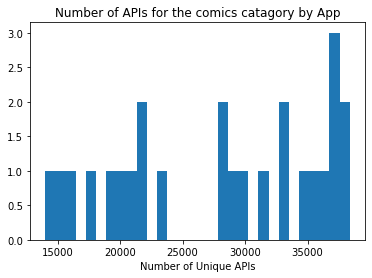

In [85]:
plt.hist(cat2CountAPI, bins=30)
plt.xlabel("Number of Unique APIs")
plt.title('Number of APIs for the comics catagory by App')

Text(0.5, 1.0, 'Number of APIs for the tools catagory by App')

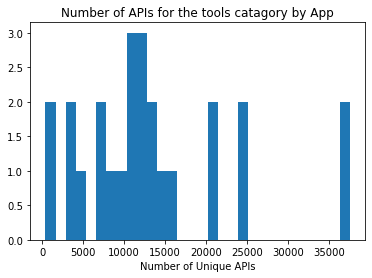

In [86]:
plt.hist(cat1CountAPI, bins=30)
plt.xlabel("Number of Unique APIs")
plt.title('Number of APIs for the tools catagory by App')

In [ ]:
# Create a Baseline Model to classify type of app catagory based on there invoke type counts and there number of unique packages
catagory = [0,0,0,0,1,1,1,1,1,1,1,1,1]
staticBeautyLi = []
virtualBeautyLi = []
directBeautyLi = []
superBeautyLi = []
interfaceBeautyLi = []

staticComicsLi = []
virtualComicsLi = []
directComicsLi = []
superComicsLi = []
interfaceComicsLi = []

uniqueComicPack = []
uniqueBeautyPack = []

comicsAppName = []
beautyAppName = []

for appName in catDict['comics']:
    superComicsLi.append(len(list(catDict['comics'][appName]['Invoke_Type']['invoke-super'])))
    interfaceComicsLi.append(len(list(catDict['comics'][appName]['Invoke_Type']['invoke-interface'])))
    directComicsLi.append(len(list(catDict['comics'][appName]['Invoke_Type']['invoke-direct'])))
    virtualComicsLi.append(len(list(catDict['comics'][appName]['Invoke_Type']['invoke-virtual'])))
    staticComicsLi.append(len(list(catDict['comics'][appName]['Invoke_Type']['invoke-static'])))
    comicsAppName.append(appName)
    
for appName in catDict['beauty']:
    superBeautyLi.append(len(list(catDict['beauty'][appName]['Invoke_Type']['invoke-super'])))
    interfaceBeautyLi.append(len(list(catDict['beauty'][appName]['Invoke_Type']['invoke-interface'])))
    directBeautyLi.append(len(list(catDict['beauty'][appName]['Invoke_Type']['invoke-direct'])))
    virtualBeautyLi.append(len(list(catDict['beauty'][appName]['Invoke_Type']['invoke-virtual'])))
    staticBeautyLi.append(len(list(catDict['beauty'][appName]['Invoke_Type']['invoke-static'])))
    beautyAppName.append(appName)
    
interfaceBeautyLi = interfaceBeautyLi[:4]
directBeautyLi = directBeautyLi[:4]
virtualBeautyLi = virtualBeautyLi[:4]
staticBeautyLi = staticBeautyLi[:4]
superBeautyLi = superBeautyLi[:4]
beautyAppName = beautyAppName[:4] 


comicsAppName = comicsAppName[1:10]
superComicsLi = superComicsLi[1:10]
interfaceComicsLi = interfaceComicsLi[1:10]
directComicsLi = directComicsLi[1:10]
virtualComicsLi = virtualComicsLi[1:10]
staticComicsLi = staticComicsLi[1:10]

beautyAppName = beautyAppName + comicsAppName
interfaceBeautyLi = interfaceBeautyLi + interfaceComicsLi
directBeautyLi = directBeautyLi + directComicsLi
virtualBeautyLi = virtualBeautyLi + virtualComicsLi
superBeautyLi = superBeautyLi + superComicsLi
staticBeautyLi = staticBeautyLi + staticComicsLi



df = pd.DataFrame()
df['AppName'] = beautyAppName
df['Interface Invoke'] = interfaceBeautyLi
df['Direct Invoke'] = directBeautyLi
df['Virtual Invoke'] = virtualBeautyLi
df['Super Invoke'] = superBeautyLi
df['Static Invoke'] = staticBeautyLi
df['label'] = catagory
df

In [ ]:
feature_cols = ['Interface Invoke', 'Direct Invoke', 'Virtual Invoke', 'Super Invoke','Static Invoke']
X = df[feature_cols] # Features
y = df.label # Target variable

logreg = RandomForestClassifier()
fitted = logreg.fit(X,y)
pred = fitted.predict(X)
fitted.score(X,y)
f1 = f1_score(y, pred, average='weighted')
f1

In [ ]:


x = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

x['outer']['appname']['Invoke_Type']['invoke-virtual'].append('sdf')
x['outer']['appname']['Invoke_Type']['invoke-virtual'] = set(x['outer']['appname']['Invoke_Type']['invoke-virtual'])

In [ ]:

line = 'Landroid/text/StaticLayout;->getHeight()'
patPack = re.compile('(.+?);')
res = re.match(patPack, line)
type(res.group(1))


In [ ]:
p = '/Users/kelkin/Documents/DSC_180A/APK_Downloads/comics/comics_3/smali/com/squareup/picasso/Utils.smali'

file1 = open(p, 'r') 
Lines = file1.readlines() 
inMethod = False  
count = 0
startMethod = '.method'
endMethod = '.end method'
# Strips the newline character 
for line in Lines: 
    if startMethod in line:
        inMethod = True
    if inMethod:
        
    print(line.strip()) 
    print("Line{}: {}".format(count, line.strip())) 

In [ ]:
'''
{
    catagory:
            {
                appName:
                        {
                            Packages: {
                                      pack_1: [API1, API2, ...] 
                                      pack_2: [API1, API2, ...]  
                                      .....
                                      }
                            
                            Methods:
                                    {
                                      method_1: [API1, API2, ...] 
                                      method_2: [API1, API2, ...]  
                                      .....
                                    }
                            
                            Invoke Type:
                                    {
                                      invoke_super: [API1, API2, ...]
                                      invoke_virtual: [API1, API2, ...]
                                    }
                            All_APIs: [API1, API2, ...]
                        }
            }
    
    
    
}
'''